## Setup

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [1]:
from getpass import getpass
import os

user = "Boyne272"
password = getpass('BitBucket password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password

!rm -r sample_data/
!git clone https://$BITBUCKET_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
!mv repo/* .
!mv repo/.git .
!rm -r repo

BitBucket password··········
rm: cannot remove 'sample_data/': No such file or directory
Cloning into 'repo'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 71 (delta 22), reused 56 (delta 14), pack-reused 0
Unpacking objects: 100% (71/71), done.
mv: cannot move 'repo/data' to './data': Directory not empty
mv: cannot move 'repo/models' to './models': Directory not empty
mv: cannot move 'repo/spec' to './spec': Directory not empty
mv: cannot move 'repo/training' to './training': Directory not empty
mv: cannot move 'repo/.git' to './.git': Directory not empty


Move to correct github branch

In [2]:
!git checkout richard
!git pull origin richard
!ls -l

M	networks.py
D	training/view_data.ipynb
Already on 'richard'
Your branch is up to date with 'origin/richard'.
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 13 (delta 6), reused 13 (delta 6), pack-reused 0
Unpacking objects: 100% (13/13), done.
From https://github.com/msc-acse/acse-8-miniproject-softmax
 * branch            richard    -> FETCH_HEAD
   1f84113..080c46a  richard    -> origin/richard
Updating 1f84113..080c46a
error: Your local changes to the following files would be overwritten by merge:
	networks.py
Please commit your changes or stash them before you merge.
Aborting
error: pathspec 'networks' did not match any file(s) known to git.
.   .config  .git	 models       __pycache__  spec  tools.py
..  data     .gitignore  networks.py  README.md    test  training


Ipython imports and functions

In [3]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Module imports

In [46]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# imports from github
from tools import *
from networks import *

# check they worked
set_seed(0)

True

Check runtime device

In [5]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [7]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


## Data pre-processing

First put in torch type with correct shape, dtype and device

In [0]:
train_feat = torch.from_numpy(train_feat)
train_feat = train_feat.float().view(-1, 1, 28, 28)

test_feat = torch.from_numpy(test_feat)
test_feat = test_feat.float().view(-1, 1, 28, 28)

train_targ = torch.from_numpy(train_targ)
train_targ = train_targ.long()

Now center and normalise

In [0]:
mean, std = train_feat.mean(), train_feat.std()

def normalise(data):
    return (data - mean) / std

train_feat = normalise(train_feat)
test_feat = normalise(test_feat)

In [10]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.size()", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 torch.Size([60000])
	 mean 	:	 undefined
	 std 	:	 undefined
	 max 	:	 tensor(9)
	 min 	:	 tensor(0)
	 type 	:	 torch.int64
test_feat
	 shape 	:	 torch.Size([10000, 1, 28, 28])
	 mean 	:	 tensor(-0.0210)
	 std 	:	 tensor(0.9807)
	 max 	:	 tensor(2.3199)
	 min 	:	 tensor(-0.5509)
	 type 	:	 torch.float32
train_feat
	 shape 	:	 torch.Size([60000, 1, 28, 28])
	 mean 	:	 tensor(-0.0003)
	 std 	:	 tensor(1.)
	 max 	:	 tensor(2.3199)
	 min 	:	 tensor(-0.5509)
	 type 	:	 torch.float32


Plot me some data

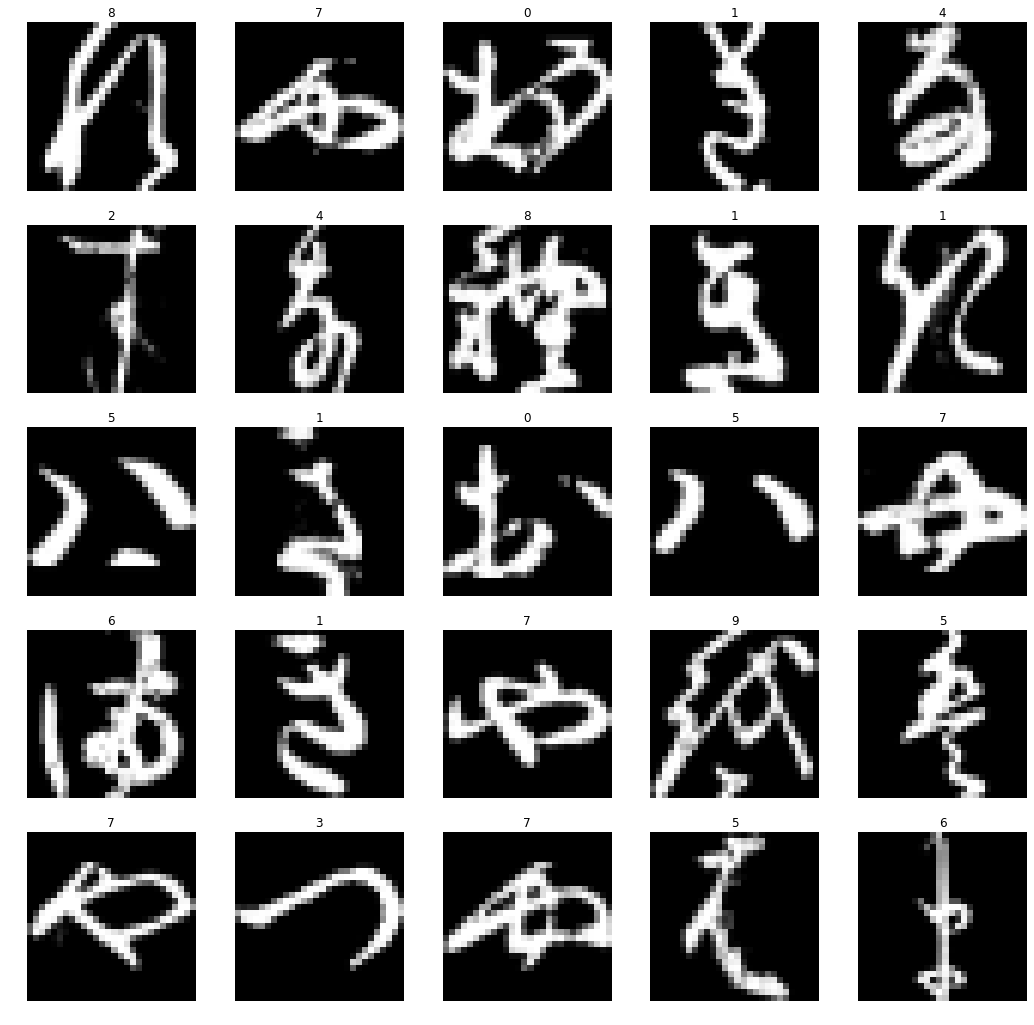

In [11]:
# setup the figure
fig, ax = plt.subplots(5, 5, figsize=[18,18])

# for each of the first 25 samples
for feat, targ, ax in zip(train_feat.data[:5*5],
                          train_targ[:5*5],
                          ax.flatten()):
    ax.imshow(feat[0, :, :], cmap="gray")
    ax.set(title=str(targ.item()))
    ax.axis("off")

## Data Splitting

Split the data with a StratifiedShuffleSplit into a 90% training 10% validation data set

In [12]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
shuffler = shuffler.split(train_feat, train_targ)

indices = list(shuffler)[0]
print(indices[0].shape, indices[1].shape)

(54000,) (6000,)


In [13]:
features_90 = train_feat[indices[0]]
targets_90 = train_targ[indices[0]]
features_10 = train_feat[indices[1]]
targets_10 = train_targ[indices[1]]

print(features_90.size(), targets_90.size(), features_10.size(), targets_10.size())

torch.Size([54000, 1, 28, 28]) torch.Size([54000]) torch.Size([6000, 1, 28, 28]) torch.Size([6000])


In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

In [0]:
# datasets
train_dataset    = TensorDataset(features_90, targets_90)
validate_dataset = TensorDataset(features_10, targets_10)
test_dataset = TensorDataset(test_feat)

# dataloaders
train_loader    = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=Test_Batch_Size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Test_Batch_Size, shuffle=False)

## Training the LeNet5 Model

In [18]:
x = torch.randn((1, 1, 28, 28))
test_model = LeNet5()
y = test_model(x)
print("Output (pre-softmax):\n", y.detach().numpy())
n_params = sum([t.detach().numpy().size for t in test_model.parameters()])
print("Number of model Parameters: ", n_params)

Output (pre-softmax):
 [[ 0.05693818 -0.07069923  0.07006929 -0.20006111  0.05587816 -0.12176653
   0.12666029 -0.05490433 -0.09893806  0.06134976]]
Number of model Parameters:  61706


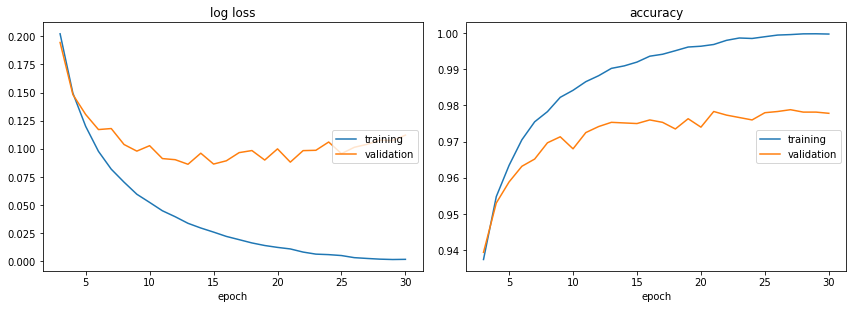

log loss:
training   (min:    0.001, max:    0.987, cur:    0.002)
validation (min:    0.086, max:    0.428, cur:    0.112)

accuracy:
training   (min:    0.682, max:    1.000, cur:    1.000)
validation (min:    0.865, max:    0.979, cur:    0.978)
Training Finished


In [19]:
set_seed(Seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum)
criterion = nn.CrossEntropyLoss()

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, validate_loader, criterion, device)
wrapper.train_model(Number_of_Epochs)

In [0]:
wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, test_loader, criterion, device)

In [48]:
output = wrapper.evaluate()
print(output)
# save_csv(output, "LeNet5_test")

[2 9 3 ... 9 4 2]
